In [0]:
import os
import shutil
import zipfile
import keras
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
import keras.backend as K
from keras.preprocessing import image
import cv2

from keras.applications.inception_v3 import InceptionV3
from keras.applications.vgg16 import VGG16

import numpy as np
import itertools
from sklearn.metrics import confusion_matrix

%matplotlib inline

import matplotlib.image as mpimg
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [0]:
if not os.path.isdir('/tmp/custom-aug'):
  os.mkdir('/tmp/custom-aug')

In [0]:
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
    -O /tmp/custom-aug/cats_and_dogs_filtered.zip
  

local_zip = '/tmp/custom-aug/cats_and_dogs_filtered.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp/custom-aug')
zip_ref.close()

--2019-07-15 10:19:50--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.15.128, 2a00:1450:400c:c06::80
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.15.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘/tmp/custom-aug/cats_and_dogs_filtered.zip’

/tmp/custom-aug/cat 100%[===================>]  65.43M  81.2MB/s    in 0.8s    

2019-07-15 10:19:51 (81.2 MB/s) - ‘/tmp/custom-aug/cats_and_dogs_filtered.zip’ saved [68606236/68606236]



In [0]:
base_dir = '/tmp/custom-aug/cats_and_dogs_filtered'

train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')                 

# Directory with our training cat pictures
train_cats_dir = os.path.join(train_dir, 'cats')

# Directory with our training dog pictures
train_dogs_dir = os.path.join(train_dir, 'dogs')

# Directory with our validation cat pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')

# Directory with our validation dog pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

In [0]:
model = keras.models.Sequential([
    keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(300, 300, 3)),
    keras.layers.MaxPooling2D(2, 2),
    keras.layers.Conv2D(64, (3,3), activation='relu'),
    keras.layers.MaxPooling2D(2,2),
    keras.layers.Conv2D(128, (3,3), activation='relu'),
    keras.layers.MaxPooling2D(2,2),
    keras.layers.Conv2D(128, (3,3), activation='relu'),
    keras.layers.MaxPooling2D(2,2),
    keras.layers.Conv2D(128, (3,3), activation='relu'),
    keras.layers.MaxPooling2D(2,2),
    keras.layers.Conv2D(128, (3,3), activation='relu'),
    keras.layers.MaxPooling2D(2,2),
    keras.layers.Flatten(),
    keras.layers.Dense(512, activation='relu'),
    keras.layers.Dense(512, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])

W0715 10:19:54.475329 139737038149504 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0715 10:19:54.525762 139737038149504 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0715 10:19:54.534376 139737038149504 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0715 10:19:54.566653 139737038149504 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.



In [0]:
model.compile(loss='binary_crossentropy',
              optimizer=RMSprop(lr=1e-4),
              metrics=['accuracy'])

W0715 10:19:54.736333 139737038149504 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0715 10:19:54.745318 139737038149504 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3376: The name tf.log is deprecated. Please use tf.math.log instead.

W0715 10:19:54.752186 139737038149504 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [0]:
target_width = 300
target_height = 300

# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(
  rescale=1./255,
  rotation_range=40,
  width_shift_range=0.2,
  height_shift_range=0.2,
  shear_range=0.2,
  zoom_range=0.2,
  horizontal_flip=True,
  fill_mode='nearest')
validation_datagen = ImageDataGenerator(rescale=1./255)

# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(
        train_dir,  # This is the source directory for training images
        target_size=(target_width, target_height),
        batch_size=20,
        class_mode='binary')

# Flow validation images in batches of 20 using test_datagen generator
validation_generator = validation_datagen.flow_from_directory(
        validation_dir,
        target_size=(target_width, target_height),
        batch_size=20,
        class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [0]:
es = keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5, restore_best_weights=True)

history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,  # 2000 images = batch_size * steps
      epochs=40,
      validation_data=validation_generator,
      validation_steps=10,
      verbose=2,
      callbacks=[es])

Epoch 1/40
 - 56s - loss: 0.6699 - acc: 0.6010 - val_loss: 0.6274 - val_acc: 0.6750
Epoch 2/40
 - 50s - loss: 0.6528 - acc: 0.6130 - val_loss: 0.7123 - val_acc: 0.4900
Epoch 3/40
 - 50s - loss: 0.6430 - acc: 0.6225 - val_loss: 0.6247 - val_acc: 0.6450
Epoch 4/40
 - 49s - loss: 0.6269 - acc: 0.6440 - val_loss: 0.5677 - val_acc: 0.7100
Epoch 5/40
 - 49s - loss: 0.6150 - acc: 0.6650 - val_loss: 0.5883 - val_acc: 0.6900
Epoch 6/40
 - 49s - loss: 0.5944 - acc: 0.6800 - val_loss: 0.5310 - val_acc: 0.7450
Epoch 7/40
 - 52s - loss: 0.5951 - acc: 0.6755 - val_loss: 0.5578 - val_acc: 0.7150
Epoch 8/40
 - 52s - loss: 0.5878 - acc: 0.6825 - val_loss: 0.6062 - val_acc: 0.6550
Epoch 9/40
 - 49s - loss: 0.5877 - acc: 0.6825 - val_loss: 0.5874 - val_acc: 0.7000
Epoch 10/40
 - 49s - loss: 0.5777 - acc: 0.6955 - val_loss: 0.5857 - val_acc: 0.6650
Epoch 11/40
 - 49s - loss: 0.5730 - acc: 0.6925 - val_loss: 0.5305 - val_acc: 0.7700
Epoch 12/40
 - 49s - loss: 0.5610 - acc: 0.7035 - val_loss: 0.5597 - val_a

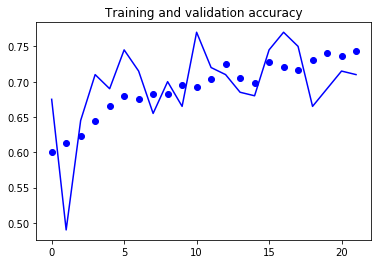

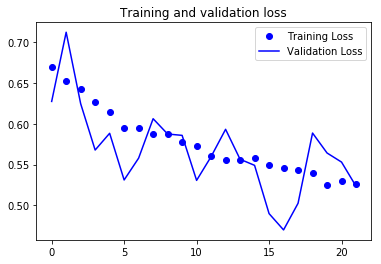

In [0]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()